In [1]:
%pip install --quiet --upgrade jupysql ipywidgets ipympl duckdb duckdb-engine pandas matplotlib jupyterlab pyarrow


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import duckdb
import pandas as pd
import ipywidgets as widgets
from matplotlib import pyplot as plt, dates, ticker
import numpy as np
%load_ext sql
%matplotlib widget

pd.options.mode.copy_on_write = True

In [3]:
%config SqlMagic.autopandas = True
%config SqlMagic.displaycon = False

In [4]:
# set some matplotlib defaults
from matplotlib.dates import DateFormatter, MinuteLocator, SecondLocator, MicrosecondLocator
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'svg')
plt.rcParams['svg.fonttype'] = 'none'
# Set the global locator and formatter
plt.rcParams['date.autoformatter.microsecond'] = '%S.%f'  # Set the global format for microsecond level
plt.rcParams['date.autoformatter.second'] = '%H:%M:%S'  # Set the global format for second level
plt.rcParams['date.autoformatter.minute'] = '%H:%M'  # Set the global format for minute level
plt.rcParams['date.autoformatter.hour'] = '%Y-%m-%d %H:%M'  # Set the global format for hour level
plt.rcParams['date.autoformatter.day'] = '%Y-%m-%d %H:%M'  # Set the global format for day level
plt.rcParams['date.autoformatter.month'] = '%Y-%m-%d %H:%M'  # Set the global format for month level
plt.rcParams['date.autoformatter.year'] = '%Y-%m-%d %H:%M'  # Set the global format for year level


In [5]:
%sql duckdb:///./391244.duckdb

Connecting to 'duckdb:///./391244.duckdb'

In [6]:
%sqlcmd tables

Name
Gateway
Site
Node
Message
Trace
Radio
Power_Consumption
Downlink_Event_Error_Message
Join_Message
Content_Message


In [7]:
hej = %sql select message from Trace WHERE message LIKE 'TIMINGS>%'

In [8]:
hej["message"][0]

'TIMINGS> Loop: 1, Sync: 806 ms, Load: 25 ms, sensor init: 9 ms, env init: 0 ms, net init: 57 ms, Collect: -1 ms, Exec: -1 ms, Send: 4084 ms, save config: 535 ms, Sleep: 10 s\n'

In [9]:
%sql nodes =<< select distinct * from Node

,node_deveui,node_appeui,node_appkey,board_id,radio_chipset,node_site,profile,riot_board
0,70B3D57ED005EA59,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,st-lrwan1,sx1276,saclay,stm32Profile,b-l072z-lrwan1


In [10]:

timestamps= %sql select timestamp from Power_Consumption 
#timestamps = timestamps["timestamp"].map(lambda x: x.isoformat())
%sql SUMMARIZE Power_Consumption

,column_name,column_type,min,max,approx_unique,avg,std,q25,q50,q75,count,null_percentage
0,power_consumption_id,INTEGER,1,1109247,1109320,554624.0,320212.1713614281,277103,555638,830050,1109247,0.0%
1,node_id,VARCHAR,70B3D57ED005EA59,70B3D57ED005EA59,1,None,None,None,None,None,1109247,0.0%
2,timestamp,TIMESTAMP,2024-02-02 13:29:02.176233,2024-02-02 13:49:07.85207,1131428,None,None,None,None,None,1109247,0.0%
3,current,FLOAT,-0.010671,0.220698,1802,0.05876333359739241,0.013526507720865565,0.05214750003070444,0.05282076922515869,0.05682715745852002,1109247,0.0%
4,voltage,FLOAT,1.51625,4.9325,401,4.8581591734201295,0.06408265403686773,4.857500076293945,4.860000133514404,4.861249923706055,1109247,0.0%
5,power,FLOAT,0.0,1.079924,506,0.2855859240795242,0.06563838951074485,0.2533749437657435,0.25672015463559655,0.2762481533689469,1109247,0.0%


In [11]:
%sql select node_id,count(*),min(timestamp),max(timestamp) from Power_Consumption group by node_id

,node_id,count_star(),"min(""timestamp"")","max(""timestamp"")"
0,70B3D57ED005EA59,1109247,2024-02-02 13:29:02.176233,2024-02-02 13:49:07.852070


Locator attempting to generate 1327 ticks ([19755.56113425926, ..., 19755.576481481483]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1327 ticks ([19755.56113425926, ..., 19755.576481481483]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1327 ticks ([19755.56113425926, ..., 19755.576481481483]), which exceeds Locator.MAXTICKS (1000).


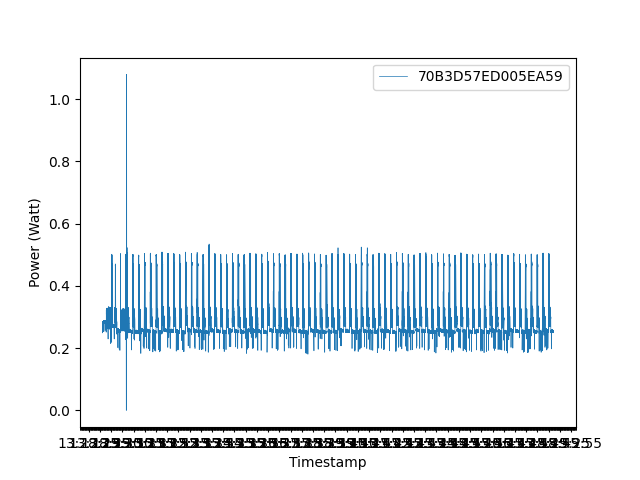

In [12]:
deveui = "70B3D57ED005EA59"

power_consumption= %sql select timestamp,power,current,voltage,node_id from Power_Consumption
power_consumption = power_consumption.set_index("timestamp")
#plot power with timestamps as x axis. timestamps need to show milliseconds
groups = power_consumption.groupby("node_id")
plt.figure()
for node_id, group in groups:
    plt.plot(group.index, group["power"], label=node_id, linewidth=0.5)

plt.xlabel("Timestamp")
plt.ylabel("Power (Watt)")
plt.gca().xaxis.set_major_locator(SecondLocator(interval=30))  # Set the major locator to display labels every 30 seconds
plt.gca().xaxis.set_minor_locator(SecondLocator(interval=1))  # Set the minor locator to display labels at millisecond level
plt.gca().xaxis.set_major_formatter(DateFormatter('%H:%M:%S')) 
#plt.gca().xaxis.set_minor_formatter(DateFormatter('%S.%f'))  
plt.legend()
plt.show()

## finding sync signals

In [13]:
BLINK_HIGH_MS = 200
BLINK_PRE_MS = 100
BLINK_POST_MS = 100

#diff of each group
power_consumption['power_diff'] = groups["power"].diff()
power_diff = power_consumption['power_diff']

# single node
power_single = power_consumption[(power_consumption["node_id"] ==deveui)]


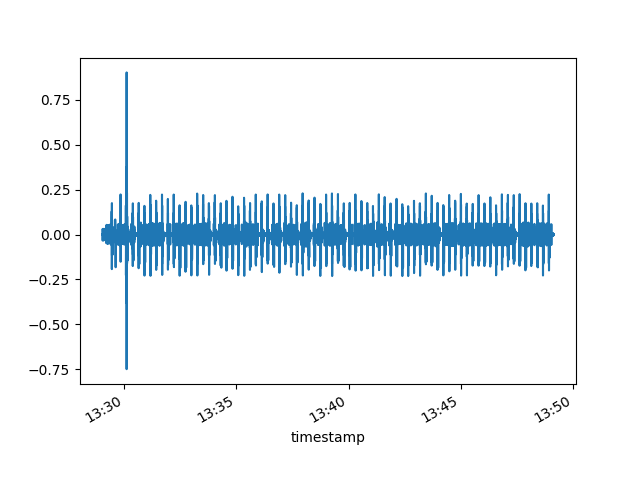

In [14]:
plt.figure()
power_diff.plot()
plt.show()

In [ ]:
rising_edge = power_consumption[power_diff > 0.1].copy()
rising_edge.loc[:,'direction'] = 'rising'
falling_edge = power_consumption[power_diff < -0.1].copy()
falling_edge.loc[:,'direction'] = 'falling'
edges = pd.concat([rising_edge, falling_edge], verify_integrity=True)
edges.sort_index(inplace=True)
edges.head()

,power,current,voltage,node_id,power_diff,direction
timestamp,,,,,,
2024-02-02 13:29:26.820471,0.493871,0.101827,4.85375,70B3D57ED005EA59,0.128809,rising
2024-02-02 13:29:27.020491,0.268607,0.055333,4.85875,70B3D57ED005EA59,-0.192299,falling
2024-02-02 13:29:27.222646,0.446255,0.091888,4.85250,70B3D57ED005EA59,0.174595,rising
2024-02-02 13:29:27.422635,0.389481,0.080143,4.85875,70B3D57ED005EA59,-0.105001,falling
2024-02-02 13:29:27.423734,0.272881,0.056139,4.86000,70B3D57ED005EA59,-0.116600,falling


Locator attempting to generate 1327 ticks ([19755.56113425926, ..., 19755.576481481483]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1327 ticks ([19755.56113425926, ..., 19755.576481481483]), which exceeds Locator.MAXTICKS (1000).


Locator attempting to generate 1327 ticks ([19755.56113425926, ..., 19755.576481481483]), which exceeds Locator.MAXTICKS (1000).


Locator attempting to generate 1327 ticks ([19755.56113425926, ..., 19755.576481481483]), which exceeds Locator.MAXTICKS (1000).


Locator attempting to generate 1327 ticks ([19755.56113425926, ..., 19755.576481481483]), which exceeds Locator.MAXTICKS (1000).


Locator attempting to generate 1327 ticks ([19755.56113425926, ..., 19755.576481481483]), which exceeds Locator.MAXTICKS (1000).


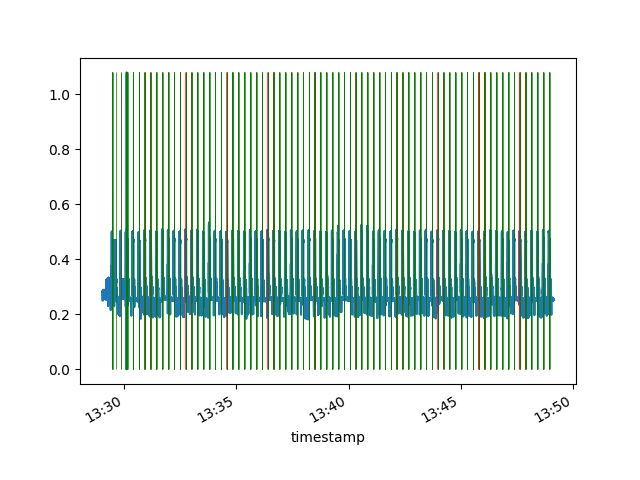

In [ ]:
plt.figure()
power_single['power'].plot(label="power")
plt.vlines(edges[edges['direction'] == 'rising'].index, ymin=power_single["power"].min(), ymax=power_single["power"].max(), color="red", linewidth=0.5)
plt.vlines(edges[edges['direction'] == 'falling'].index, ymin=power_single["power"].min(), ymax=power_single["power"].max(), color="green", linewidth=0.5)

plt.show()

In [ ]:
# only keep edges where direction differ
edges['next_direction'] = edges['direction'].shift(-1)
edges['next_timestamp'] = edges.index.to_series().shift(-1)

# filter out edges that are too close to each other or too far apart. We add 10% tolerance
edges = edges[(edges['direction'] == "rising") & (edges['next_direction'] == "falling") & ((edges['next_timestamp'] - edges.index < pd.Timedelta(milliseconds=BLINK_HIGH_MS + (BLINK_HIGH_MS/10)))  & (edges['next_timestamp'] - edges.index > pd.Timedelta(milliseconds=BLINK_HIGH_MS - (BLINK_HIGH_MS/10))))]
edges.head()


,power,current,voltage,node_id,power_diff,direction,next_direction,next_timestamp
timestamp,,,,,,,,
2024-02-02 13:29:26.820471,0.493871,0.101827,4.85375,70B3D57ED005EA59,0.128809,rising,falling,2024-02-02 13:29:27.020491
2024-02-02 13:29:27.222646,0.446255,0.091888,4.85250,70B3D57ED005EA59,0.174595,rising,falling,2024-02-02 13:29:27.422635
2024-02-02 13:30:04.564449,0.498145,0.102657,4.85625,70B3D57ED005EA59,0.161775,rising,falling,2024-02-02 13:30:04.764438
2024-02-02 13:30:04.966593,0.420004,0.086443,4.85625,70B3D57ED005EA59,0.147123,rising,falling,2024-02-02 13:30:05.167681
2024-02-02 13:30:07.136050,0.506691,0.104293,4.85375,70B3D57ED005EA59,0.107443,rising,falling,2024-02-02 13:30:07.336039


In [ ]:
## add counter to sync signals and add sync signal start and end times
edges.loc[:,'sync_num'] = range(len(edges)) 
edges.loc[:, 'sync_start'] = edges.index - pd.Timedelta(milliseconds=100)
edges.loc[:, 'sync_end'] = edges.next_timestamp + pd.Timedelta(milliseconds=100)
edges.head()

,power,current,voltage,node_id,power_diff,direction,next_direction,next_timestamp,sync_num,sync_start,sync_end
timestamp,,,,,,,,,,,
2024-02-02 13:29:26.820471,0.493871,0.101827,4.85375,70B3D57ED005EA59,0.128809,rising,falling,2024-02-02 13:29:27.020491,0,2024-02-02 13:29:26.720471,2024-02-02 13:29:27.120491
2024-02-02 13:29:27.222646,0.446255,0.091888,4.85250,70B3D57ED005EA59,0.174595,rising,falling,2024-02-02 13:29:27.422635,1,2024-02-02 13:29:27.122646,2024-02-02 13:29:27.522635
2024-02-02 13:30:04.564449,0.498145,0.102657,4.85625,70B3D57ED005EA59,0.161775,rising,falling,2024-02-02 13:30:04.764438,2,2024-02-02 13:30:04.464449,2024-02-02 13:30:04.864438
2024-02-02 13:30:04.966593,0.420004,0.086443,4.85625,70B3D57ED005EA59,0.147123,rising,falling,2024-02-02 13:30:05.167681,3,2024-02-02 13:30:04.866593,2024-02-02 13:30:05.267681
2024-02-02 13:30:07.136050,0.506691,0.104293,4.85375,70B3D57ED005EA59,0.107443,rising,falling,2024-02-02 13:30:07.336039,4,2024-02-02 13:30:07.036050,2024-02-02 13:30:07.436039


Locator attempting to generate 1327 ticks ([19755.56113425926, ..., 19755.576481481483]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1327 ticks ([19755.56113425926, ..., 19755.576481481483]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1327 ticks ([19755.56113425926, ..., 19755.576481481483]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1327 ticks ([19755.56113425926, ..., 19755.576481481483]), which exceeds Locator.MAXTICKS (1000).


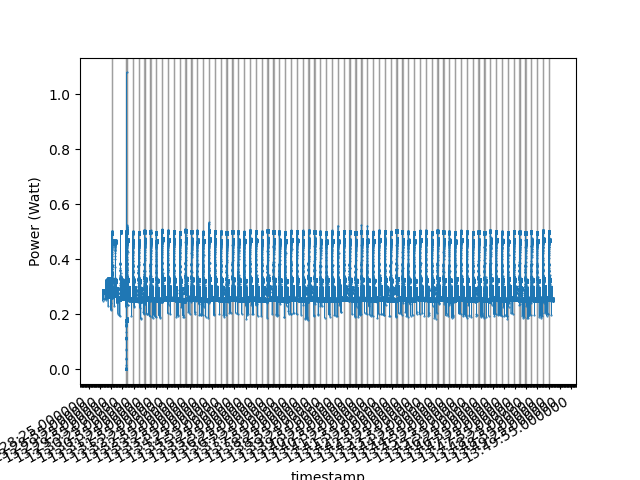

In [ ]:
# visually verify sync signals
plt.figure()
power_single['power'].plot(style='.',markersize=1, label="power")
power_single['power'].plot(linewidth=0.5, color='tab:blue', label="power")
plt.ylabel("Power (Watt)")

## add sync signal indication
for row in edges.itertuples():
    plt.axvspan(row.sync_start, row.sync_end, color='grey', alpha=0.5, label="sync signal")

plt.gca().xaxis.set_major_locator(SecondLocator(interval=30))
plt.gca().xaxis.set_minor_locator(SecondLocator(interval=1))

plt.gca().xaxis.set_major_formatter(DateFormatter('%H:%M:%S.%f'))  # Set the date format for the tick labels

#plt.gca().xaxis.set_minor_locator(dates.AutoDateLocator(minticks=10, maxticks=20))

plt.gcf().autofmt_xdate()
plt.show()

In [ ]:
# every loop starts with 2 sync signals right after each other
# find all sync signals where the next start is very close to previous end
edges['next_sync_start'] = edges['sync_start'].shift(-1)
edges['next_sync_end'] = edges['sync_end'].shift(-1)
loops = edges[(abs(edges['sync_end'] - edges['next_sync_start']) < pd.Timedelta(milliseconds=500))][['node_id', 'sync_start', 'next_sync_end']].copy()
loops.rename(columns={'sync_start': 'loop_signal_start', 'next_sync_end': 'loop_signal_end'}, inplace=True)
loops['loop_num'] = range(len(loops))
loops.head()

,node_id,loop_signal_start,loop_signal_end,loop_num
timestamp,,,,
2024-02-02 13:29:26.820471,70B3D57ED005EA59,2024-02-02 13:29:26.720471,2024-02-02 13:29:27.522635,0
2024-02-02 13:30:04.564449,70B3D57ED005EA59,2024-02-02 13:30:04.464449,2024-02-02 13:30:05.267681,1
2024-02-02 13:30:07.136050,70B3D57ED005EA59,2024-02-02 13:30:07.036050,2024-02-02 13:30:07.838214,2
2024-02-02 13:30:22.802813,70B3D57ED005EA59,2024-02-02 13:30:22.702813,2024-02-02 13:30:23.504977,3
2024-02-02 13:30:38.471834,70B3D57ED005EA59,2024-02-02 13:30:38.371834,2024-02-02 13:30:39.173968,4


/home/kasper/.local/lib/python3.10/site-packages/ipympl/backend_nbagg.py:336: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.figure.savefig(buf, format='png', dpi='figure')


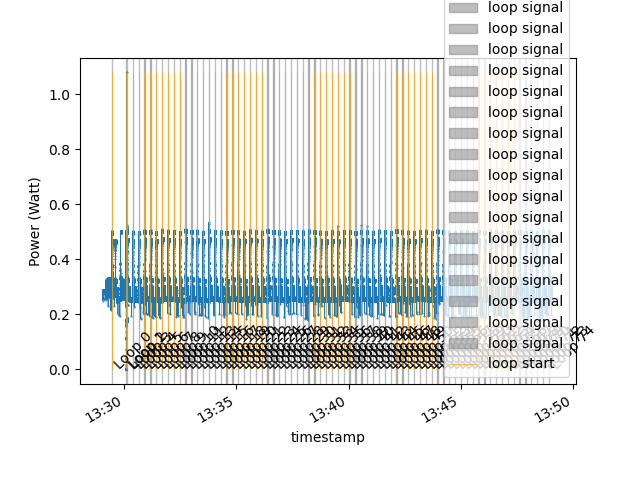

Locator attempting to generate 1327 ticks ([19755.56113425926, ..., 19755.576481481483]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1327 ticks ([19755.56113425926, ..., 19755.576481481483]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1327 ticks ([19755.56113425926, ..., 19755.576481481483]), which exceeds Locator.MAXTICKS (1000).
/home/kasper/.local/lib/python3.10/site-packages/ipympl/backend_nbagg.py:279: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.manager.handle_json(content)
Locator attempting to generate 1327 ticks ([19755.56113425926, ..., 19755.576481481483]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1327 ticks ([19755.56113425926, ..., 19755.576481481483]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1327 ticks ([19755.56113425926, ..., 19755.576481481483]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to gener

In [ ]:
plt.figure()
power_single['power'].plot(style='.',markersize=1, label="power")
power_single['power'].plot(linewidth=0.5, color='tab:blue', label="power")
plt.ylabel("Power (Watt)")

## add sync signal indication
for row in loops.itertuples():
    plt.axvspan(row.loop_signal_start, row.loop_signal_end, color='tab:gray', alpha=0.5, label="loop signal")
    plt.text(row.Index, 0, f"Loop {row.loop_num}", rotation=45)
# plt.vlines(edges.index, ymin=power_single["power"].min(), ymax=power_single["power"].max(), color="red", linewidth=0.5, label="rising edge")
# plt.vlines(edges['next_timestamp'], ymin=power_single["power"].min(), ymax=power_single["power"].max(), color="green", linewidth=0.5, label="falling edge")
plt.vlines(loops.index, ymin=power_single["power"].min(), ymax=power_single["power"].max(), color="orange", linewidth=0.5, label="loop start")

plt.legend()
plt.show()

In [ ]:
# 'TIMINGS> Loop: 0, Sync: 806 ms, Load: 40 ms, sensor init: 10 ms, env init: 0 ms, net init: 5216 ms, Collect: -1 ms, Exec: -1 ms, Send: 5119 ms, save config: 2646 ms, Sleep: 9 s\n'
query = """
SELECT 
    node_id,
    timestamp,
    regexp_extract(message, 'Loop: (-?[0-9]+)',1) as loop_num,
    regexp_extract(message, '.*Sync: (-?[0-9]+)',1) as sync_time_ms,
    regexp_extract(message, '.*Load: (-?[0-9]+)',1) as load_time_ms,
    regexp_extract(message, '.*sensor init: (-?[0-9]+)',1) as sensor_init_time_ms,
    regexp_extract(message, '.*env init: (-?[0-9]+)',1) as env_init_time_ms,
    regexp_extract(message, '.*net init: (-?[0-9]+)',1) as net_init_time_ms,
    --regexp_extract(message, '.*Listen: (-?[0-9]+)',1) as listen_time_ms,
    regexp_extract(message, '.*Collect: (-?[0-9]+)',1) as collect_time_ms,
    regexp_extract(message, '.*Exec: (-?[0-9]+)',1) as exec_time_ms,
    regexp_extract(message, '.*Send: (-?[0-9]+)',1) as send_time_ms,
    regexp_extract(message, '.*save config: (-?[0-9]+)',1) as save_config_time_ms,
    regexp_extract(message, '.*Sleep: (-?[0-9]+)',1) as sleep_time_s
FROM Trace
WHERE message LIKE 'TIMINGS>%'
"""
timings = %sql {{query}}
timings.head()

,node_id,timestamp,loop_num,sync_time_ms,load_time_ms,sensor_init_time_ms,env_init_time_ms,net_init_time_ms,collect_time_ms,exec_time_ms,send_time_ms,save_config_time_ms,sleep_time_s
0,70B3D57ED005EA59,2024-02-02 13:30:12.574441,1,806,25,9,0,57,-1,-1,4084,535,10
1,70B3D57ED005EA59,2024-02-02 13:30:28.243690,2,806,25,9,0,57,-1,-1,4086,534,10
2,70B3D57ED005EA59,2024-02-02 13:30:43.912808,3,806,25,9,0,57,-1,-1,4086,534,10
3,70B3D57ED005EA59,2024-02-02 13:30:59.583186,4,806,25,9,0,57,-1,-1,4087,535,10
4,70B3D57ED005EA59,2024-02-02 13:31:15.252338,5,806,25,9,0,57,-1,-1,4087,534,10


In [ ]:
# since duckdb return all columns as object we need to change types before we can merge
timings[['loop_num', 'sync_time_ms', 'load_time_ms', 'sensor_init_time_ms', 'env_init_time_ms', 'net_init_time_ms', 'collect_time_ms', 'exec_time_ms', 'send_time_ms', 'save_config_time_ms', 'sleep_time_s']] = timings[['loop_num', 'sync_time_ms', 'load_time_ms', 'sensor_init_time_ms', 'env_init_time_ms', 'net_init_time_ms', 'collect_time_ms', 'exec_time_ms', 'send_time_ms', 'save_config_time_ms', 'sleep_time_s']].apply(pd.to_numeric)

# .. and merge. here we need to reset index first, since df.merge doesnt preserve index
loops = loops.reset_index().merge(timings, on=['node_id', 'loop_num']).set_index('loop_signal_start')
loops.head()

,timestamp_x,node_id,loop_signal_end,loop_num,timestamp_y,sync_time_ms,load_time_ms,sensor_init_time_ms,env_init_time_ms,net_init_time_ms,collect_time_ms,exec_time_ms,send_time_ms,save_config_time_ms,sleep_time_s
loop_signal_start,,,,,,,,,,,,,,,
2024-02-02 13:30:04.464449,2024-02-02 13:30:04.564449,70B3D57ED005EA59,2024-02-02 13:30:05.267681,1,2024-02-02 13:30:12.574441,806,25,9,0,57,-1,-1,4084,535,10
2024-02-02 13:30:07.036050,2024-02-02 13:30:07.136050,70B3D57ED005EA59,2024-02-02 13:30:07.838214,2,2024-02-02 13:30:28.243690,806,25,9,0,57,-1,-1,4086,534,10
2024-02-02 13:30:22.702813,2024-02-02 13:30:22.802813,70B3D57ED005EA59,2024-02-02 13:30:23.504977,3,2024-02-02 13:30:43.912808,806,25,9,0,57,-1,-1,4086,534,10
2024-02-02 13:30:38.371834,2024-02-02 13:30:38.471834,70B3D57ED005EA59,2024-02-02 13:30:39.173968,4,2024-02-02 13:30:59.583186,806,25,9,0,57,-1,-1,4087,535,10
2024-02-02 13:30:54.040856,2024-02-02 13:30:54.140856,70B3D57ED005EA59,2024-02-02 13:30:54.844088,5,2024-02-02 13:31:15.252338,806,25,9,0,57,-1,-1,4087,534,10


Locator attempting to generate 1327 ticks ([19755.56113425926, ..., 19755.576481481483]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1327 ticks ([19755.56113425926, ..., 19755.576481481483]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1327 ticks ([19755.56113425926, ..., 19755.576481481483]), which exceeds Locator.MAXTICKS (1000).
/home/kasper/.local/lib/python3.10/site-packages/ipympl/backend_nbagg.py:336: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.figure.savefig(buf, format='png', dpi='figure')


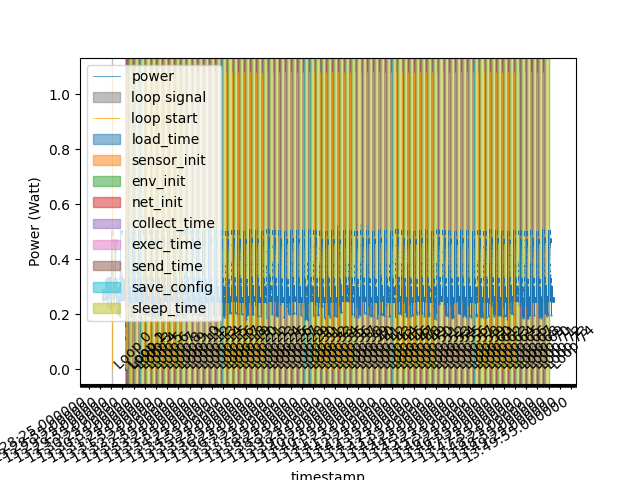

In [ ]:

loops["start_time"] = loops.index
loops["sync_start"] = loops["start_time"]
loops["sync_end"] = loops["sync_start"] + pd.to_timedelta(loops["sync_time_ms"], unit="ms")
loops["load_start"] = loops["sync_end"]
loops["load_end"] = loops["load_start"] + pd.to_timedelta(loops["load_time_ms"], unit="ms")
loops["sensor_init_start"] = loops["load_end"]
loops["sensor_init_end"] = loops["sensor_init_start"] + pd.to_timedelta(loops["sensor_init_time_ms"], unit="ms")
loops["env_init_start"] = loops["sensor_init_end"]
loops["env_init_end"] = loops["env_init_start"] + pd.to_timedelta(loops["env_init_time_ms"], unit="ms")
loops["net_init_start"] = loops["env_init_end"]
loops["net_init_end"] = loops["net_init_start"] + pd.to_timedelta(loops["net_init_time_ms"], unit="ms")
loops["collect_time_start"] = loops["net_init_end"]
loops["collect_time_end"] = loops["collect_time_start"] +pd.to_timedelta(loops["collect_time_ms"], unit="ms")
loops["exec_start"] = loops["collect_time_end"]
loops["exec_end"] = loops["exec_start"] + pd.to_timedelta(loops["exec_time_ms"], unit="ms")
loops["send_start"] = loops["exec_end"]
loops["send_end"] = loops["send_start"] +pd.to_timedelta(loops["send_time_ms"], unit="ms")
loops["save_config_start"] = loops["send_end"]
loops["save_config_end"] = loops["save_config_start"] + pd.to_timedelta(loops["save_config_time_ms"], unit="ms")
loops["sleep_start"] = loops["save_config_end"]
loops["sleep_end"] = loops["sleep_start"] + pd.to_timedelta(loops["sleep_time_s"], unit="s")

loops.replace(-1,0) # remove -1 values. They show up if the time measurement is not available

for row in loops.itertuples():
    plt.axvspan(row.load_start, row.load_end, color='tab:blue', alpha=0.5, label="load_time")
    plt.axvspan(row.sensor_init_start, row.sensor_init_end, color='tab:orange', alpha=0.5, label="sensor_init")
    plt.axvspan(row.env_init_start, row.env_init_end, color='tab:green', alpha=0.5, label="env_init")
    plt.axvspan(row.net_init_start, row.net_init_end, color='tab:red', alpha=0.5, label="net_init")
    plt.axvspan(row.collect_time_start, row.collect_time_end, color='tab:purple', alpha=0.5, label="collect_time")
    plt.axvspan(row.exec_start, row.exec_end, color='tab:pink', alpha=0.5, label="exec_time")
    plt.axvspan(row.send_start, row.send_end, color='tab:brown', alpha=0.5, label="send_time")
    plt.axvspan(row.save_config_start, row.save_config_end, color='tab:cyan', alpha=0.5, label="save_config")
    plt.axvspan(row.sleep_start, row.sleep_end, color='tab:olive', alpha=0.5, label="sleep_time")
# this to remove duplicate labels https://stackoverflow.com/questions/13588920/stop-matplotlib-repeating-labels-in-legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.gca().xaxis.set_major_locator(SecondLocator(interval=30))
plt.gca().xaxis.set_minor_locator(SecondLocator(interval=1))

plt.gca().xaxis.set_major_formatter(DateFormatter('%H:%M:%S.%f'))  # Set the date format for the tick labels
plt.show()

## Add events if any

In [ ]:
# get all relevant frame-events
%sql send_frame_start << select * from Trace WHERE message LIKE '%send frame%'
%sql send_frame_end << select * from Trace WHERE message LIKE '%Transmission completed%'
%sql receive_frame_start << select * from Trace WHERE message LIKE '%RX started%'
%sql receive_frame_end << select * from Trace WHERE message LIKE '%received something%'

In [ ]:
#drop first row of send_frame_end and receive_frame_start since thats from the join procedure
send_frame_end = send_frame_end.iloc[1:]
receive_frame_start = receive_frame_start.iloc[1:]

# confirm the 2 pairs of start/end all have the same length
assert len(send_frame_start) == len(send_frame_end), f"send frame event mismatch. start {len(send_frame_start)}, end { len(send_frame_end)}"
assert len(receive_frame_start) == len(receive_frame_end), f"receive frame event mismatch  {len(receive_frame_start)}, end { len(receive_frame_end)}"

Locator attempting to generate 1327 ticks ([19755.56113425926, ..., 19755.576481481483]), which exceeds Locator.MAXTICKS (1000).


Locator attempting to generate 1327 ticks ([19755.56113425926, ..., 19755.576481481483]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1327 ticks ([19755.56113425926, ..., 19755.576481481483]), which exceeds Locator.MAXTICKS (1000).
/home/kasper/.local/lib/python3.10/site-packages/ipympl/backend_nbagg.py:336: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.figure.savefig(buf, format='png', dpi='figure')


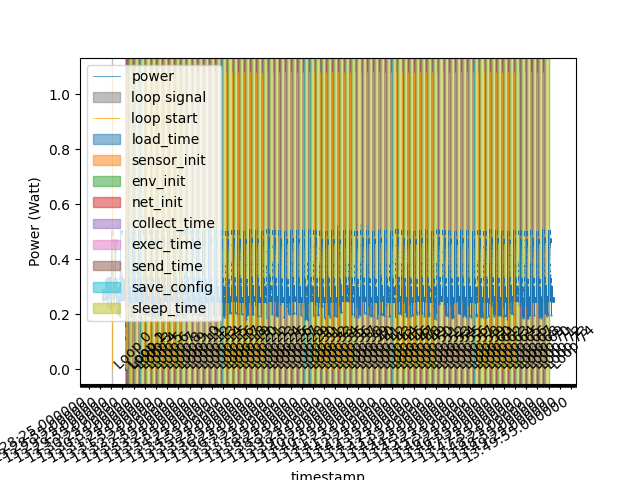

In [ ]:
# add send and receive columns to plot

for send_start_row, send_end_row in zip(send_frame_start.itertuples(), send_frame_end.itertuples()):
    start_time = send_start_row.timestamp
    end_time = send_end_row.timestamp
    plt.axvspan(start_time, end_time, color='tab:pink', alpha=0.5, label="send_events")

for receive_frame_start, receive_frame_end in zip(receive_frame_start.itertuples(), receive_frame_end.itertuples()):
    start_time = receive_frame_start.timestamp
    end_time = receive_frame_end.timestamp
    plt.axvspan(start_time, end_time, color='tab:brown', alpha=0.5, label="receive_events")


handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.show()

In [ ]:
%sql SELECT * from Content_Message

,content_message_id,frame_counter,frame_port,frame_payload
0,1,-1,1,ChQKEgoQCgwKAggACgIQCAoCCAoQAQ==


In [ ]:
%%sql
SELECT
    through_gateway,
    gateway_received_at,
    app_received_at,
    rssi,
    snr,
    bandwidth,
    frequency,
    consumed_airtime_s,
    spreading_factor,
    coding_rate,
    frame_counter,
    frame_port,
    frame_payload,
    from_base64(frame_payload) as decoded_payload,
    related_node,
    network_received_at
FROM
    Uplink_Message,
    Content_Message,
    Message 
WHERE
    Uplink_Message.uplink_message_id = Message.message_id AND
    Content_Message.content_message_id = Message.message_id

,through_gateway,gateway_received_at,app_received_at,rssi,snr,bandwidth,frequency,consumed_airtime_s,spreading_factor,coding_rate,frame_counter,frame_port,frame_payload,decoded_payload,related_node,network_received_at


## Calculate Total Energy Consumed per region

In [ ]:
def calc_energy_consumed(df: pd.DataFrame):
    # Assume df have columns "power" and index of "timestamp" type.
    # create a copy of the dataframe with only index and power
    if len(df) == 0:
        return 0
    power = df[["power"]]

    #power["power_diff"] = power.diff().shift(-1) #  current - previous, shifted one back so it becomes next - current. i.e. current + diff = next
    power["time_diff"] = abs(power.index.diff(-1)) # abs(next-current)
    us_per_s = 1_000_000
    power["time_diff_s"] = power["time_diff"].dt.microseconds / us_per_s # get timediff in fractions of a second
    power = power.drop(power.index[-1]) # drop last row since it has no next and therefore should be NaN
    return sum(power["power"] * power["time_diff_s"]) # returns the sum of power times fractions of a second. Since power is in W and time_diff_s is in seconds it is in W*s or J

calc_energy_consumed(power_single)
power_single.head()

,power,current,voltage,node_id,power_diff
timestamp,,,,,
2024-01-30 13:33:52.975361,0.281427,0.057873,4.86000,70B3D57ED005EA59,NaN
2024-01-30 13:33:52.976459,0.280817,0.057824,4.86000,70B3D57ED005EA59,-0.000610
2024-01-30 13:33:52.977527,0.280206,0.057629,4.86250,70B3D57ED005EA59,-0.000611
2024-01-30 13:33:52.978626,0.280206,0.057653,4.86125,70B3D57ED005EA59,0.000000
2024-01-30 13:33:52.979694,0.280817,0.057775,4.85750,70B3D57ED005EA59,0.000611


,power,current,voltage,node_id,power_diff
timestamp,,,,,
2024-02-02 13:29:02.176233,0.278985,0.057433,4.86125,70B3D57ED005EA59,NaN
2024-02-02 13:29:02.177301,0.278375,0.057335,4.85875,70B3D57ED005EA59,-0.000610
2024-02-02 13:29:02.178399,0.278985,0.057384,4.86000,70B3D57ED005EA59,0.000610
2024-02-02 13:29:02.179467,0.279596,0.057531,4.85750,70B3D57ED005EA59,0.000611
2024-02-02 13:29:02.180566,0.279596,0.057506,4.85875,70B3D57ED005EA59,0.000000


In [ ]:
# loops contain the start and end times of each activity, so loop over loops and calculate the energy for each activity
def calc_energy_consumed_per_activity(series_loops: pd.Series) -> pd.Series:
    return pd.Series({
        "total": calc_energy_consumed(power_single.loc[series_loops.name:series_loops["sleep_end"]]),
        "loop signal": calc_energy_consumed(power_single.loc[series_loops.name:series_loops["loop_signal_end"]]),
        "total without loop signal": calc_energy_consumed(power_single.loc[series_loops["loop_signal_end"]:series_loops["sleep_end"]]),
        "load config": calc_energy_consumed(power_single.loc[series_loops["load_start"]:series_loops["load_end"]]),
        "sensor init": calc_energy_consumed(power_single.loc[series_loops["sensor_init_start"]:series_loops["sensor_init_end"]]),
        "env init": calc_energy_consumed(power_single.loc[series_loops["env_init_start"]:series_loops["env_init_end"]]),
        "net init": calc_energy_consumed(power_single.loc[series_loops["net_init_start"]:series_loops["net_init_end"]]),
        "sensor collect": calc_energy_consumed(power_single.loc[series_loops["collect_time_start"]:series_loops["collect_time_end"]]),
        "query execution": calc_energy_consumed(power_single.loc[series_loops["exec_start"]:series_loops["exec_end"]]),
        "send": calc_energy_consumed(power_single.loc[series_loops["send_start"]:series_loops["send_end"]]),
        "save config": calc_energy_consumed(power_single.loc[series_loops["save_config_start"]:series_loops["save_config_end"]]),
        "sleep": calc_energy_consumed(power_single.loc[series_loops["sleep_start"]:series_loops["sleep_end"]]),
    })
energy_consumed = loops.apply(calc_energy_consumed_per_activity, axis=1)
energy_consumed_summary = energy_consumed.describe()
energy_consumed_summary

,total,loop signal,total without loop signal,load config,sensor init,env init,net init,sensor collect,query execution,send,save config,sleep
count,73.000000,73.000000,73.000000,73.000000,73.000000,73.0,73.000000,73.0,73.0,73.000000,73.000000,73.000000
mean,4.421063,0.309745,4.111006,0.006930,0.002192,0.0,0.016329,0.0,0.0,1.382536,0.157071,2.544237
std,0.025696,0.001863,0.024359,0.000054,0.000038,0.0,0.000128,0.0,0.0,0.018478,0.001637,0.021024
min,4.376319,0.306675,4.066903,0.006835,0.002152,0.0,0.016117,0.0,0.0,1.243779,0.147744,2.515090
25%,4.401579,0.308261,4.092917,0.006888,0.002173,0.0,0.016222,0.0,0.0,1.376274,0.156097,2.529030
50%,4.417880,0.309465,4.108290,0.006924,0.002185,0.0,0.016313,0.0,0.0,1.384267,0.157029,2.540477
75%,4.441492,0.311165,4.132256,0.006968,0.002203,0.0,0.016437,0.0,0.0,1.391364,0.158131,2.555512
max,4.479669,0.314068,4.165591,0.007051,0.002470,0.0,0.016617,0.0,0.0,1.402213,0.159632,2.648429


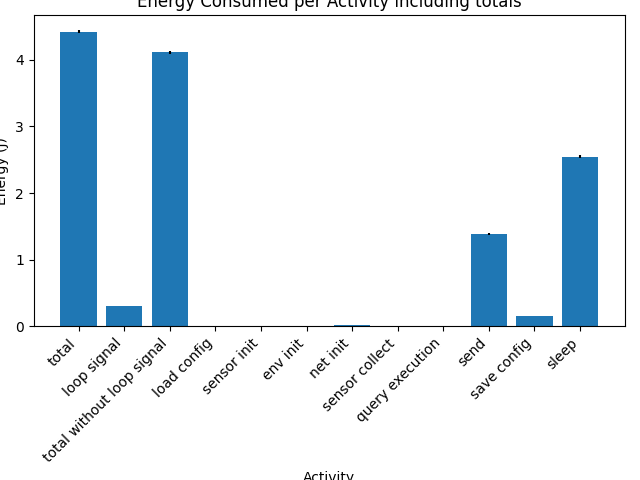

In [ ]:
# plot barchart with stddev error bars
plt.figure()
plt.bar(energy_consumed_summary.columns, energy_consumed_summary.loc["mean"], yerr=energy_consumed_summary.loc["std"])
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.xlabel("Activity")
plt.ylabel("Energy (J)")
plt.title("Energy Consumed per Activity including totals")
plt.show()

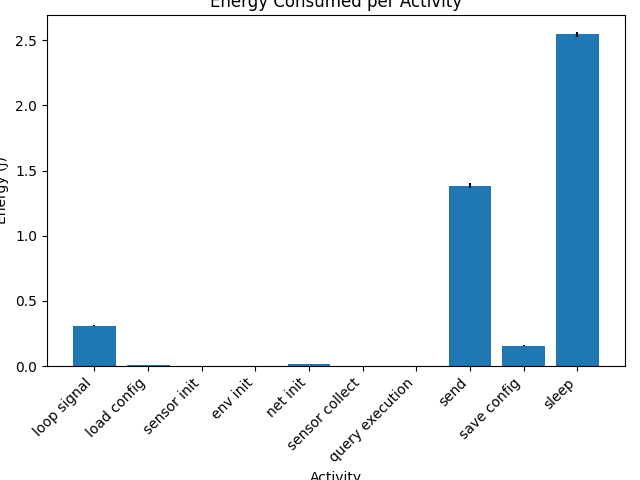

In [ ]:
# plot barchart without totals 
plt.figure()
energy_consumed_summary_no_totals = energy_consumed_summary.drop(["total", "total without loop signal"], axis=1)
plt.bar(energy_consumed_summary_no_totals.columns, energy_consumed_summary_no_totals.loc["mean"], yerr=energy_consumed_summary_no_totals.loc["std"])
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.xlabel("Activity")
plt.ylabel("Energy (J)")
plt.title("Energy Consumed per Activity")
plt.show()